In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/daily_sales_french_bakery.csv", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df = df.drop(["unit_price"], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


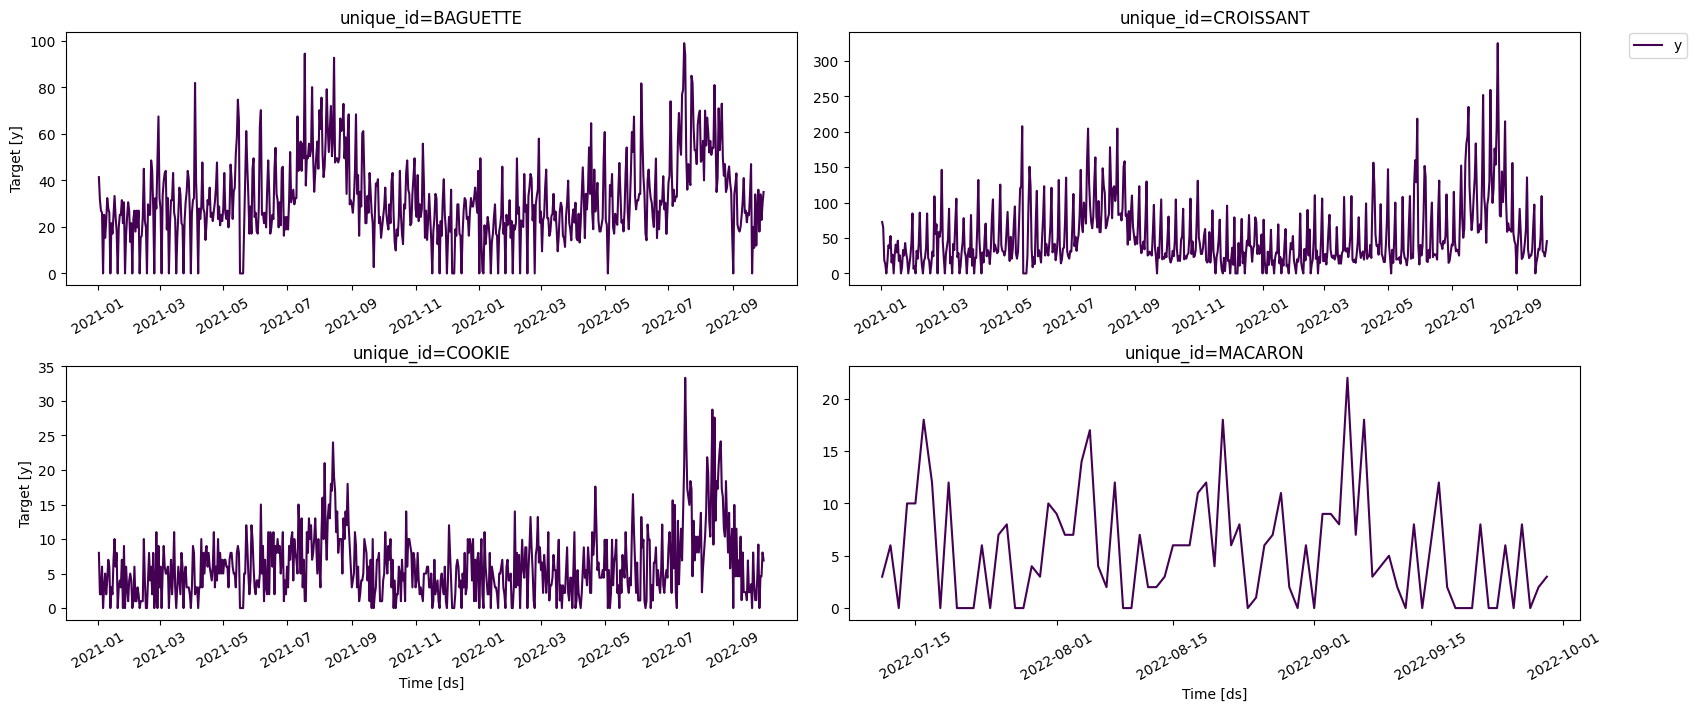

In [3]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT", "COOKIE", "MACARON"], palette="viridis")

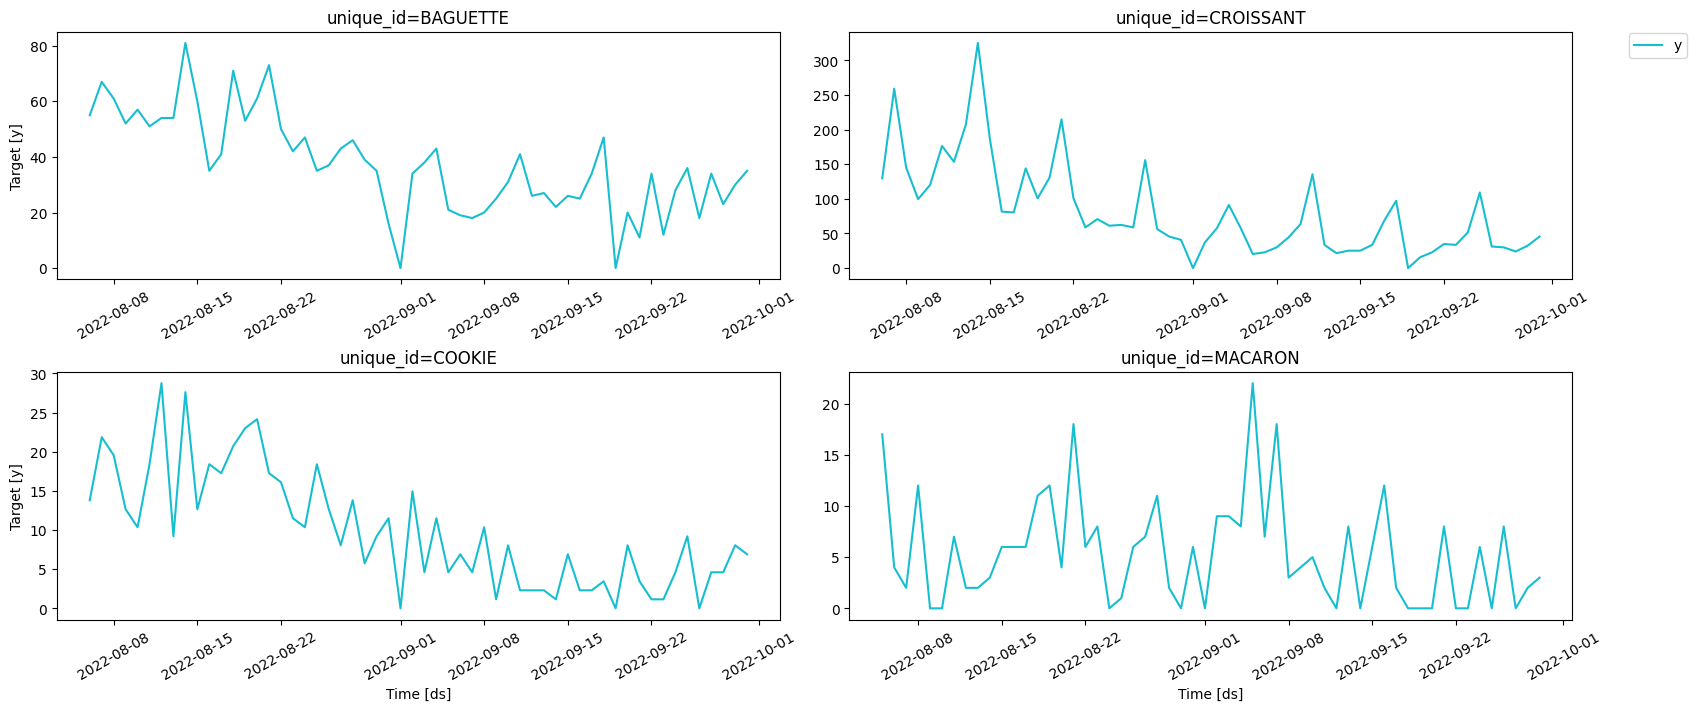

In [4]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT", "COOKIE", "MACARON"], max_insample_length=56)
# last 56 time stamps

In [5]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [6]:
horizon = 7 # daily data (7 days)

models = [
    Naive(), # last known timestep
    HistoricAverage(), # average of entire history
    WindowAverage(window_size=7), # calculate average of 7 days
    SeasonalNaive(season_length=7) # seasonality of data is 7 days
]

sf = StatsForecast(models=models, freq="D") # daily frequency
sf.fit(df=df)

prediction = sf.predict(h=horizon)

In [7]:
prediction.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


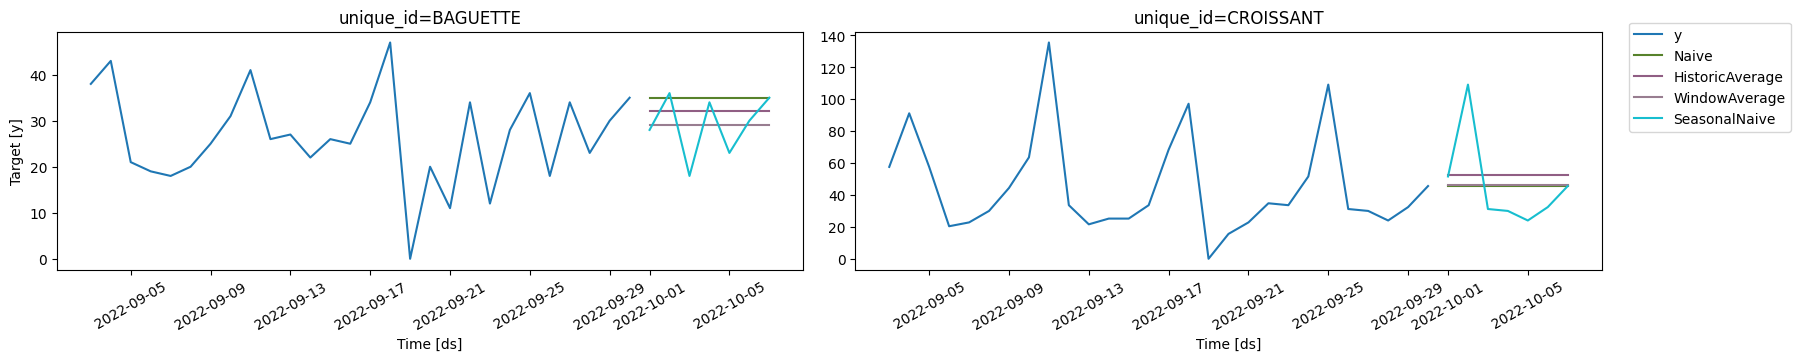

In [8]:
plot_series(
    df=df,
    forecasts_df=prediction,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28
)

In [9]:
test = df.groupby("unique_id").tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [10]:
sf.fit(df=train)
prediction = sf.predict(h=horizon)
eval_df = pd.merge(test, prediction, 'left', ['ds', 'unique_id'])

In [11]:
evaluation = evaluate(
    eval_df,
    metrics=[mae], 
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [12]:
evaluation = evaluation.drop('unique_id', axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


* ARIMA (AutoRegressive Integrated Moving Average) model
* Exponencial smoothing
* Theta model (decomposition approach)
* MSTL, BATS, TBATS (multiple seasonal periods)
* Croston, IMAPA, TSB (intermediate series)

* ARIMA is suitable for single seasonal data

In [13]:
from statsforecast.models import AutoARIMA

In [14]:
unique_ids = ["BAGUETTE", "CROISSANT"]

small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, "inner", ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [15]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


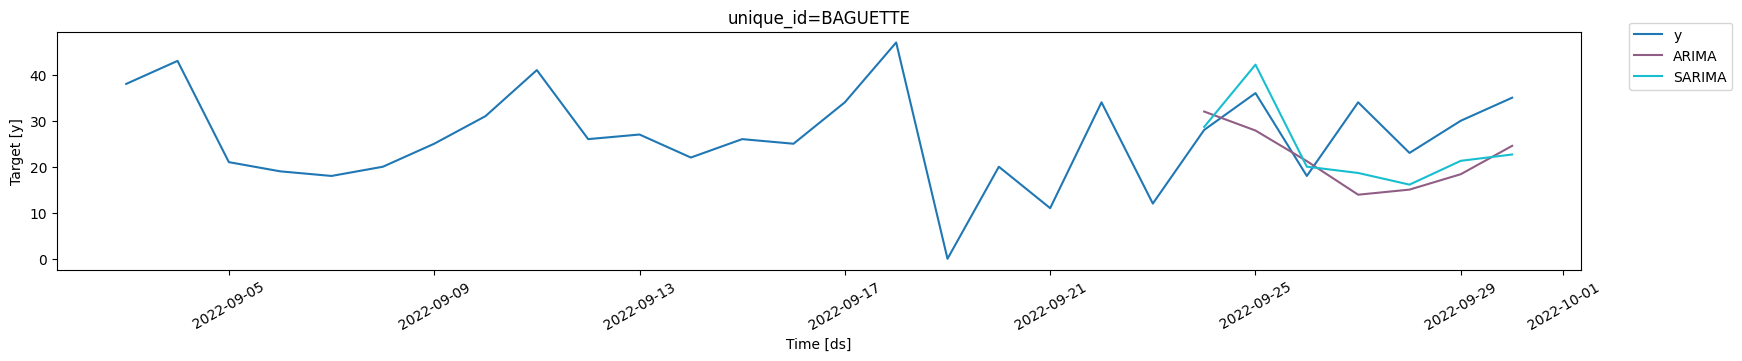

In [16]:
plot_series(
    df=df,
    forecasts_df=arima_preds,
    ids=["BAGUETTE"],
    max_insample_length=28,
)

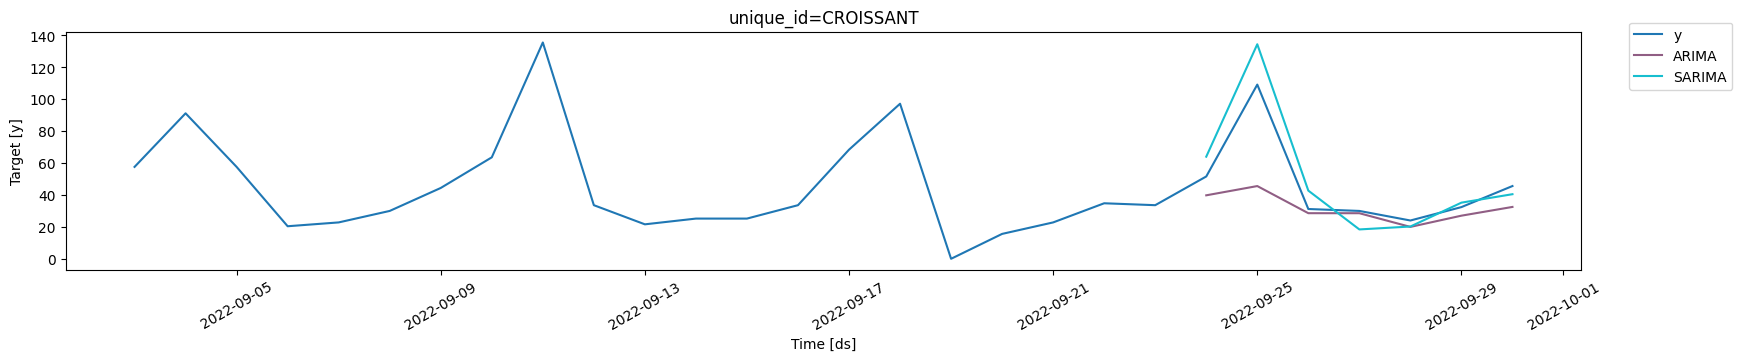

In [17]:
plot_series(
    df=df,
    forecasts_df=arima_preds,
    ids=["CROISSANT"],
    max_insample_length=28,
)

* Cross Validation

In [18]:
small_df = df[df["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
cv_df = sf.cross_validation(
    h=horizon,
    df=small_df,
    n_windows=8,
    refit=True, # do we want to reoptimize model everytime input size changes
)

cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-09-17,2022-09-16,34.0,31.0,36.576285,34.989613
1,BAGUETTE,2022-09-18,2022-09-16,47.0,41.0,37.235963,46.596384
2,BAGUETTE,2022-09-19,2022-09-16,0.0,26.0,32.344139,29.512186
3,BAGUETTE,2022-09-20,2022-09-16,20.0,27.0,25.271113,23.839057
4,BAGUETTE,2022-09-21,2022-09-16,11.0,22.0,21.590900,22.342629


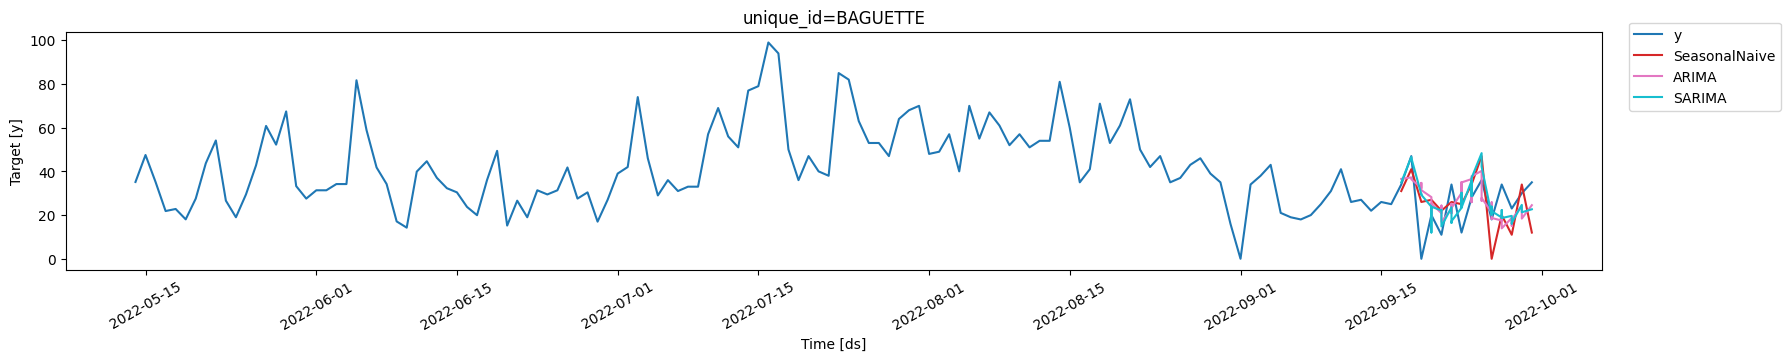

In [19]:
plot_series(
    df=small_df,
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
    ids=["BAGUETTE"],
    max_insample_length=140
)

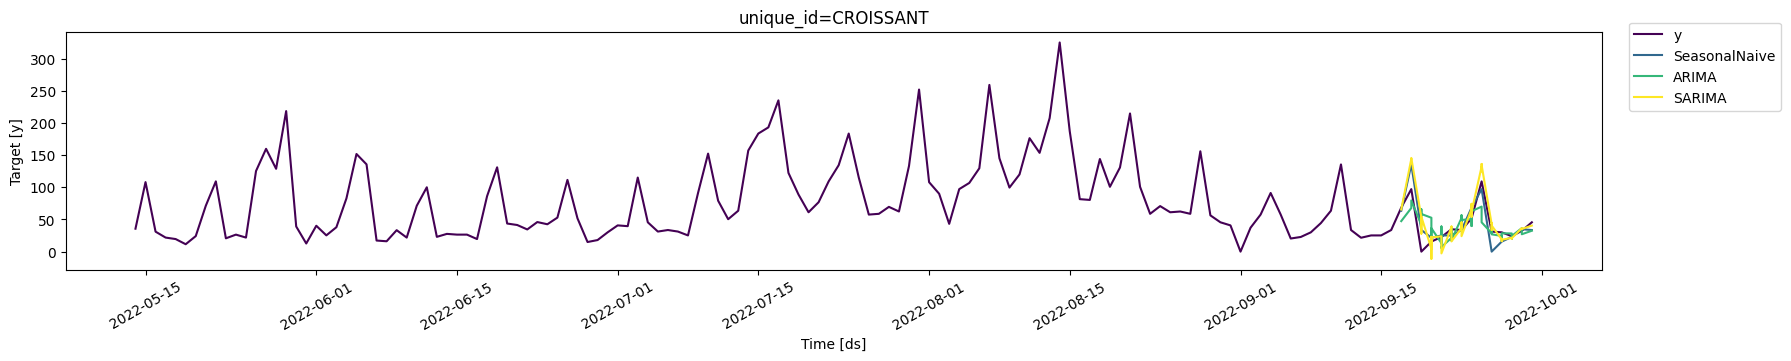

In [20]:
plot_series(
    df=small_df,
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1),
    ids=["CROISSANT"],
    max_insample_length=140,
    palette="viridis"
)

In [21]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_eval = cv_eval.drop(["unique_id"], axis=1).groupby("metric").mean().reset_index()
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,11.925,14.31519,11.774462
